In [1]:
pwd

'/home/dmarx/projects/whats-in-a-name'

In [2]:
with open('chatgpt_names.cleaned.txt') as f:
    names = f.read().split('\n')
print(len(names))

1433


In [88]:
first_names = list(set([name.split()[0].lower() for name in names if '.' not in name]))
first_names.sort()
len(first_names)

1081

In [85]:
first_names[:10]

['aamir',
 'aarif',
 'aaron',
 'abby',
 'abdullah',
 'abhay',
 'abhishek',
 'abigail',
 'adam',
 'adil']

In [87]:
last_names = list(set([name.split()[-1].lower() for name in names if '.' not in name]))
last_names.sort()
len(last_names)

1235

In [40]:
from pathlib import Path
from diffusers import StableDiffusionPipeline
import torch
import diffusers
import time
import torch
import matplotlib.pyplot as plt
import PIL
import numpy as np
import gc
from copy import deepcopy
from collections import Counter
import gc
from scipy.spatial.distance import pdist

In [89]:
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
                model_id,
                revision="fp16",
                #torch_dtype=torch.float16,
                #use_auth_token=True
            ).to('cuda')

# https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/scheduler/scheduler_config.json
true, false, null = True, False, None
pipe.scheduler = diffusers.EulerDiscreteScheduler(
    **{
      "beta_end": 0.012,
      "beta_schedule": "scaled_linear",
      "beta_start": 0.00085,
      "interpolation_type": "linear",
      "num_train_timesteps": 1000,
      "prediction_type": "epsilon",
      "steps_offset": 1,
      "timestep_spacing": "leading",
      "trained_betas": null,
      "use_karras_sigmas": false
    }
)

# disable safety checker

#pipe.requires_safety_checker=False
def passthrough(images, *args, **kargs):
    return images, [False for _ in images]
pipe.safety_checker = passthrough

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/dmarx/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [90]:
#root = Path("images-gpt-diversity")
root = Path("images-gpt-diversity_firstnames")

In [91]:
# RUN THIS CELL TO GENERATE IMAGES

if 'clip_model' in locals():
    del clip_model
    gc.collect()
    torch.cuda.empty_cache()

kwargs = dict(
    num_inference_steps=35, #25,
    num_images_per_prompt= 12, # 16 # oh nice, i just assumed that would OOM # 8
    negative_prompt="b&w photography, collage, crowded",
)


#images_per_prompt = 24 #40
#images_per_prompt = 64
# fuck it.
images_per_name = 12

#for i, name in enumerate(names):
for i, name in enumerate(first_names):
    print((i,name))
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    #prompt_clean = prompt.replace(',','')
    #outdir = root / prompt_clean.replace(' ','_')  
    outdir = root / name
    outdir.mkdir(parents=True, exist_ok=True)
    # TODO: add a jsonl metadata listing image fpaths and prompts
    while len(list(outdir.glob('*.png'))) < images_per_name:
        outv = pipe(prompt, **kwargs)
        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)


(0, 'aamir')


  0%|          | 0/35 [00:00<?, ?it/s]

(1, 'aarif')


  0%|          | 0/35 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.00 GiB (GPU 0; 23.69 GiB total capacity; 9.83 GiB already allocated; 1.31 GiB free; 13.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
import torch
from PIL import Image
import open_clip

emb_suffix = ".clip_vitb32_laion2b_s34b_b79k.embed"
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

clip_model.eval()
clip_model.to('cuda')

def image2clip(image):
    #image = clip_preprocess(image).unsqueeze(0)
    with torch.no_grad(), torch.cuda.amp.autocast():
        image = clip_preprocess(image).unsqueeze(0).to('cuda')
        image_features = clip_model.encode_image(image)
    return image_features

In [19]:
# RUN THIS CELL TO GENERATE CLIP EMBEDS

# 1. glob images from folder
# 2. load iamge
# 3. project image
# 4. construct outname from inname
# 5. persist embed


errors = []

#for fpath in Path('images-gpt-diversity').rglob('*'):
for fpath in root.rglob('*'):
    if not fpath.is_dir():
        continue
    #if 'full_frame' not in str(fpath):
    #    continue
    if '.ipynb_checkpoints' in str(fpath):
        continue
    outdir = fpath
    
    print(outdir)


    image_paths = outdir.glob('*.png')
    # glob embeds, only project images that we haven't already embedded
    embed_paths = [str(p) for p in outdir.glob(f"{emb_suffix}.npy")]
    
    with torch.no_grad():
        for fpath in image_paths:
            # skip images we've already embedded
            embed_path = outdir / (fpath.stem + emb_suffix)
            if str(embed_path) in embed_paths:
                continue
            try:
                im = PIL.Image.open(fpath)
                #embed = image2dino(im)
                embed = image2clip(im)
            # some weird PIL error on 
            except:
                errors.append(fpath)
                continue
            
            #torch.save(embed, embed_path) # 2.3mb for a 1x384 vector? wtf?
            arr = np.array(embed.cpu())
            # 1kb instead of 2mb
            np.save(embed_path, arr) # adds ".npy" extension. whatever.
    #break
print(errors)

images-gpt-diversity/John Legend
images-gpt-diversity/Magic Johnson
images-gpt-diversity/Isabelle Kaif
images-gpt-diversity/Marit Bjørgen
images-gpt-diversity/BoA (Kwon Bo-ah)
images-gpt-diversity/Rohit Sharma
images-gpt-diversity/Goldie Hawn
images-gpt-diversity/Hicham El Guerrouj
images-gpt-diversity/Holly Hunter
images-gpt-diversity/Vic Zhou
images-gpt-diversity/Christopher Nolan
images-gpt-diversity/Jet Li
images-gpt-diversity/Angela Bassett
images-gpt-diversity/Namie Amuro
images-gpt-diversity/Antonio Banderas
images-gpt-diversity/Sebastián Yatra
images-gpt-diversity/Wu Jinyan
images-gpt-diversity/Timothée Chalamet
images-gpt-diversity/Kriti Sanon
images-gpt-diversity/Nicole Scherzinger
images-gpt-diversity/Lou Diamond Phillips
images-gpt-diversity/Whitney Houston
images-gpt-diversity/Aidana Medenova
images-gpt-diversity/Haruma Miura
images-gpt-diversity/Bong Joon-ho
images-gpt-diversity/Will Pan
images-gpt-diversity/Izara Aishah
images-gpt-diversity/Manny Pacquiao
images-gpt-dive

In [68]:
# load embeddings

# ok, so having confirmed that CLIP-ViTB/32 gets the job done here,
# let's re-calibrate the number of samples needed to estimate identity rigidity

# recs = []
# for k,v in embeds_cache.items():
#     rec = {'root':k}
#     break

# actually, fuck the embeds cache, let's build this object up from scratch.
# make it all nice n shit.

# ```

recs = []
for class_idx, fpath in enumerate(root.rglob('*')):
    if not fpath.is_dir():
        continue
    if '.ipynb_checkpoints' in str(fpath):
        continue   
    prompted_name = fpath.stem
    #print(prompted_name)
    #break

    
    embed_paths = list(fpath.glob(f"*embed*.npy"))
    for epath in embed_paths:
        embed = np.load(epath)
        image_id, embed_type = epath.name.split('.',1)
        
        rec={
            'class_idx':class_idx,
            'name':prompted_name,
            'root':fpath,
            'image_id':image_id,
            'embed_type':embed_type,
            'path':epath,
            'embed':embed,
            'embed_normed':embed / np.linalg.norm(embed),
        }
        recs.append(rec)

        
import pandas as pd
df_embeds = pd.DataFrame(recs)

In [69]:
#len(df_embeds)
df_embeds['name'].value_counts().value_counts()

count
12    1425
Name: count, dtype: int64

In [102]:
embeds_i = np.array([e.ravel() for e in df_name['embed_normed']])
pdist(embeds_i, 'cosine').shape

(66,)

In [105]:
%%time
# this isn't the most efficient way to do this, but it'll
# at least make sense statistically and be easy to implement.
# 
# loop over each image, sample n images for same name,
# compute summary statistic at n
# compute for all n

df_clip = df_embeds

#n_values = list(range(32, 129, 8))
n_values=[12]

for n in n_values:
    col_names = [f"similarity@{n}", f"DIV@{n}"]
    for col_name in col_names:
        if col_name not in df_clip.columns:
            df_clip.loc[:,col_name] = np.nan

# deepcopy so we can mutate df_clip
for name, df_name in deepcopy(df_clip).groupby('name'):
    #print(name)
    
    for n in n_values:
        col_name = f"DIV@{n}"
        #pdist_n = pdist(df_name['embed_normed'], 'cosine').mean()
        #df_clip.loc[df_name.index, col_name] = pdist_n
        embeds_i = np.array([e.ravel() for e in df_name['embed_normed']])
        pdist_n = pdist(embeds_i, 'cosine')
        df_clip.loc[df_name.index, col_name] = pdist_n.mean()
        
    for image_id in df_name['image_id']:
        df_rest = df_name[df_name['image_id']!=image_id]
        embed_i = df_name[df_name['image_id']==image_id]['embed_normed']
        # there's definitely a better way to do this...
        rec_idx = embed_i.index[0]
        embed_i = embed_i[embed_i.index[0]]
        
        def centroid_at_n(n):
            """
            samples n observations and returns their centroid
            """
            if n<len(df_rest):
                df_sample = df_rest.sample(n-1)
            else:
                df_sample = df_rest
            centroid = df_sample['embed_normed'].sum()
            if n<len(df_rest):
                centroid = centroid + embed_i # [embed_i.index[0]] #embed_i
            centroid = centroid / np.linalg.norm(centroid)
            return centroid

        for n in n_values:
            centroid = centroid_at_n(n)
            similarity = centroid @ embed_i.T
            
            col_name = f"similarity@{n}"
            df_clip.loc[rec_idx, col_name] = similarity

CPU times: user 21.5 s, sys: 8.23 ms, total: 21.5 s
Wall time: 21.5 s


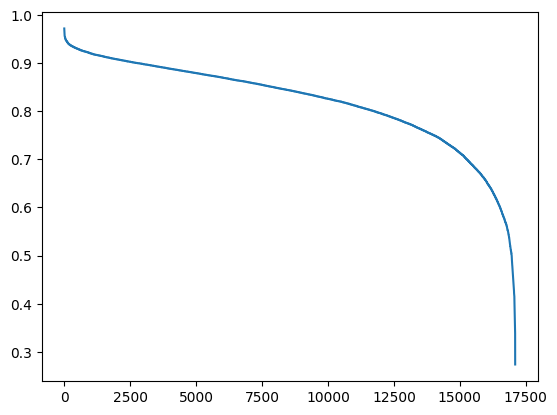

In [71]:
arr = df_clip['similarity@12'].values
arr.sort()
plt.plot(arr[::-1])

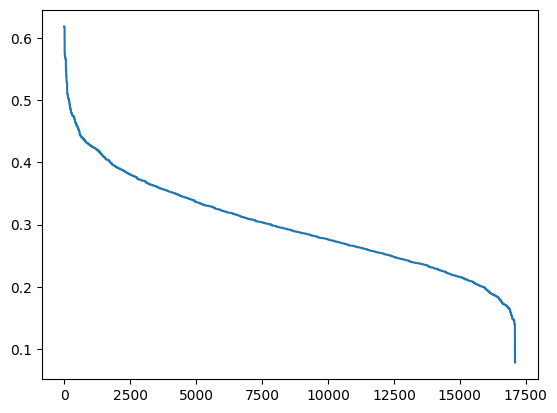

In [111]:
arr = df_clip['DIV@12'].values
arr.sort()
plt.plot(arr[::-1]) # hmm

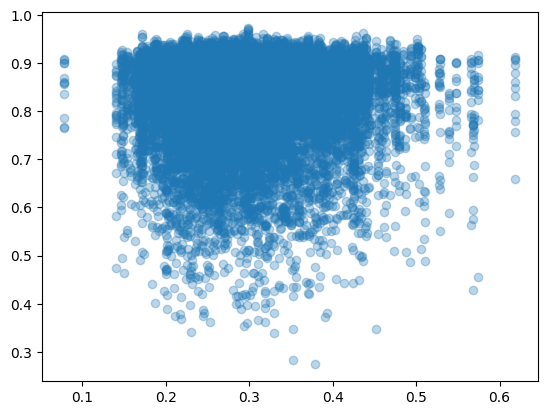

In [110]:
plt.scatter(df_clip['DIV@12'], df_clip['similarity@12'], alpha=0.3)
plt.show()

In [ ]:
arr = df_clip['similarity@12'].values
arr.sort()
plt.plot(arr[::-1])

In [44]:
# q=.1
# thresholded_scores = Counter()
# for name, df_name in df_clip.groupby('name'):
#     thresh = df_name['similarity@12'].quantile(q)
#     df_q = df_name[df_name['similarity@12'] > thresh]
#     thresholded_scores[name] = df_q['similarity@12'].mean()
#     # oh right, need to recompute centroid after dropping the bad records. ugh.
# df_thresholded = pd.Series(thresholded_scores).sort_values(ascending=False)
# for i, (name, value) in enumerate(df_thresholded.items()):
#     print(f"{i}\t{value:.2f}\t{name}")

<Axes: xlabel='name'>

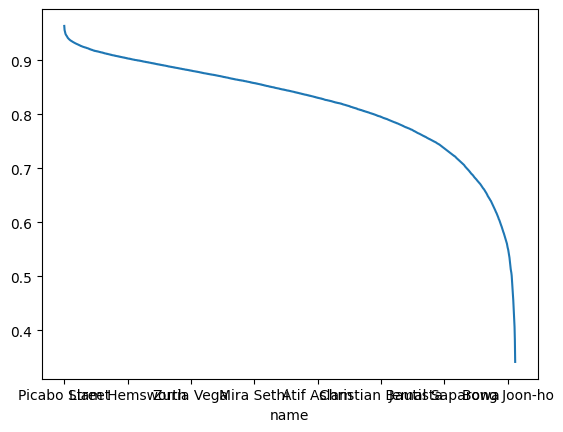

In [72]:
df_names_ranked = df_clip.groupby('name')['similarity@12'].mean().sort_values(ascending=False)
#df_names_ranked[df_names_ranked>.8]
#for rank, (name, score) in enumerate(df_names_ranked.items()):
#    print(f"{rank}\t{score}\t{name}")
df_names_ranked.plot()

In [49]:
for rank, (name, score) in enumerate(df_names_ranked.items()):
    print(f"{rank}\t{score:.3f}\t{name}")

0	0.964	Picabo Street
1	0.956	Bradley Cooper
2	0.954	Siti Badriah
3	0.951	H.E.R.
4	0.949	Toše Proeski
5	0.948	Martin Scorsese
6	0.947	Ayim Mukhamedjanova
7	0.946	Takeshi Kaneshiro
8	0.945	Diana Hayden
9	0.944	Kathem Al-Saher
10	0.943	Nikhil Advani
11	0.942	Jason Bateman
12	0.941	Ricky Schroder
13	0.940	Cicely Tyson
14	0.940	Tim Robbins
15	0.939	Diya Mirza
16	0.939	Joseph Gordon-Levitt
17	0.938	Cote de Pablo
18	0.938	Chen Daoming
19	0.937	Ronaldinho
20	0.937	Shirley MacLaine
21	0.937	Tom Hardy
22	0.936	Yalitza Aparicio
23	0.936	Hu Ge
24	0.935	Yassi Pressman
25	0.935	Ranbir Kapoor
26	0.935	Simone Manuel
27	0.934	Ayesha Takia
28	0.934	Ian Somerhalder
29	0.934	Salman Ahmad
30	0.933	Rosie Perez
31	0.933	Sandhya Mridul
32	0.933	Marilyn Monroe
33	0.932	Kirsten Dunst
34	0.932	Allu Arjun
35	0.932	Antonio Aguilar
36	0.931	Zhou Xun
37	0.931	Sebastian Castro
38	0.931	Yoo Jae-suk
39	0.931	Gauhar Khan
40	0.930	Anil Kapoor
41	0.930	Sara Ali Khan
42	0.930	Miranada Ayim
43	0.930	Meryl Streep
44	0.929	S

In [73]:
df_names_ranked.to_csv('2023-09-30_names_ranked.gpt-diversity.csv')

In [74]:
#np.array(df_embeds['embed_normed']).shape
#df_embeds.shape
classes = np.array([class_idx for class_idx in df_embeds['class_idx']])
embeds = np.array([emb.ravel() for emb in df_embeds['embed_normed']])
embeds.shape # (17100, 512)


(17100, 512)

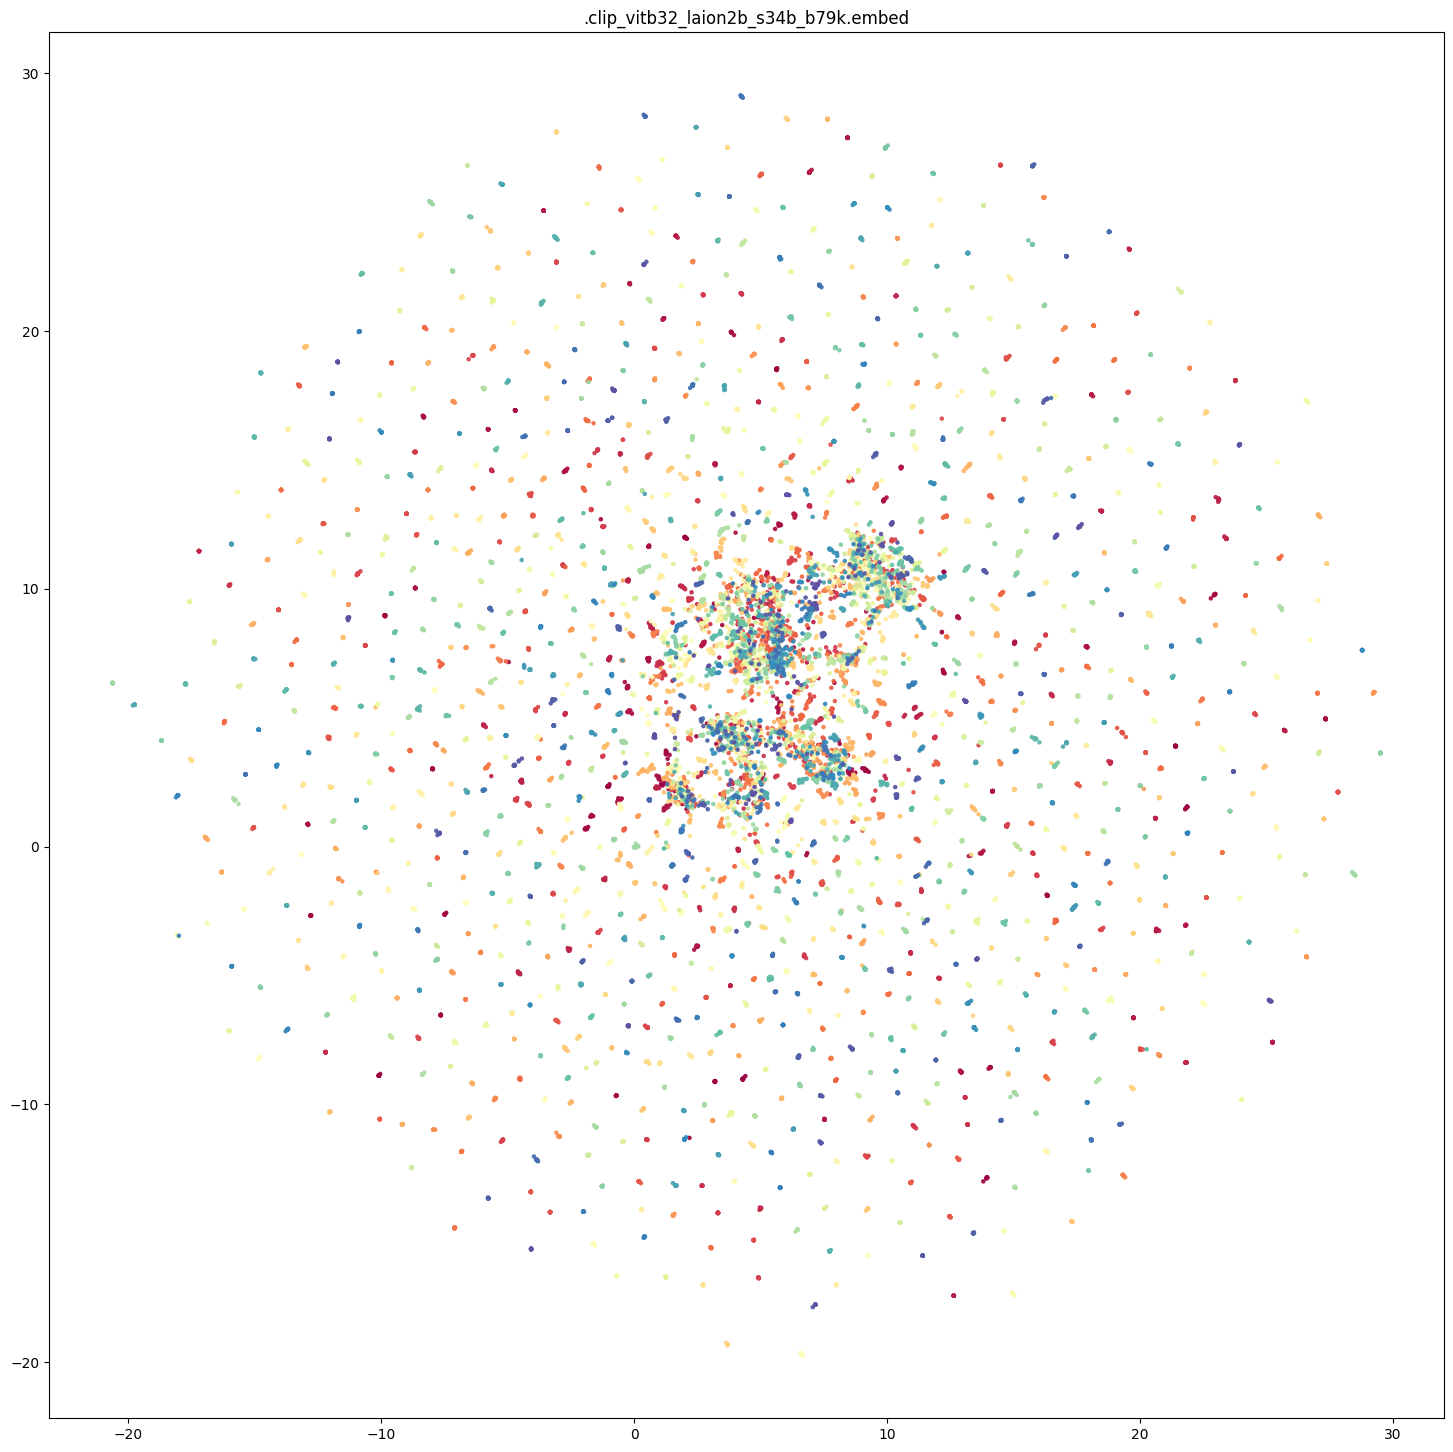

CPU times: user 7min 30s, sys: 4min 35s, total: 12min 6s
Wall time: 44.1 s


In [78]:
%%time

# vits

import umap

umap_model = umap.UMAP(
    n_neighbors=64, #20,
    #min_dist=.001,
    init='spectral',
    n_epochs=100,
    #local_connectivity=2,
    negative_sample_rate=20,
    repulsion_strength=1.5,
    #spread =1,
)
#umap_embeds = umap_model.fit_transform(df_embeds['embed_normed'], y=df_embeds['name'])
umap_embeds = umap_model.fit_transform(embeds, classes)

plt.scatter(
    *umap_embeds.T,
    s=5, 
    c=classes,
    cmap='Spectral',
    alpha=.9)
plt.title(f"{emb_suffix}")

fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.savefig("umap-supervised_gpt-celebs.png")

plt.show()
# WAAAAAY better

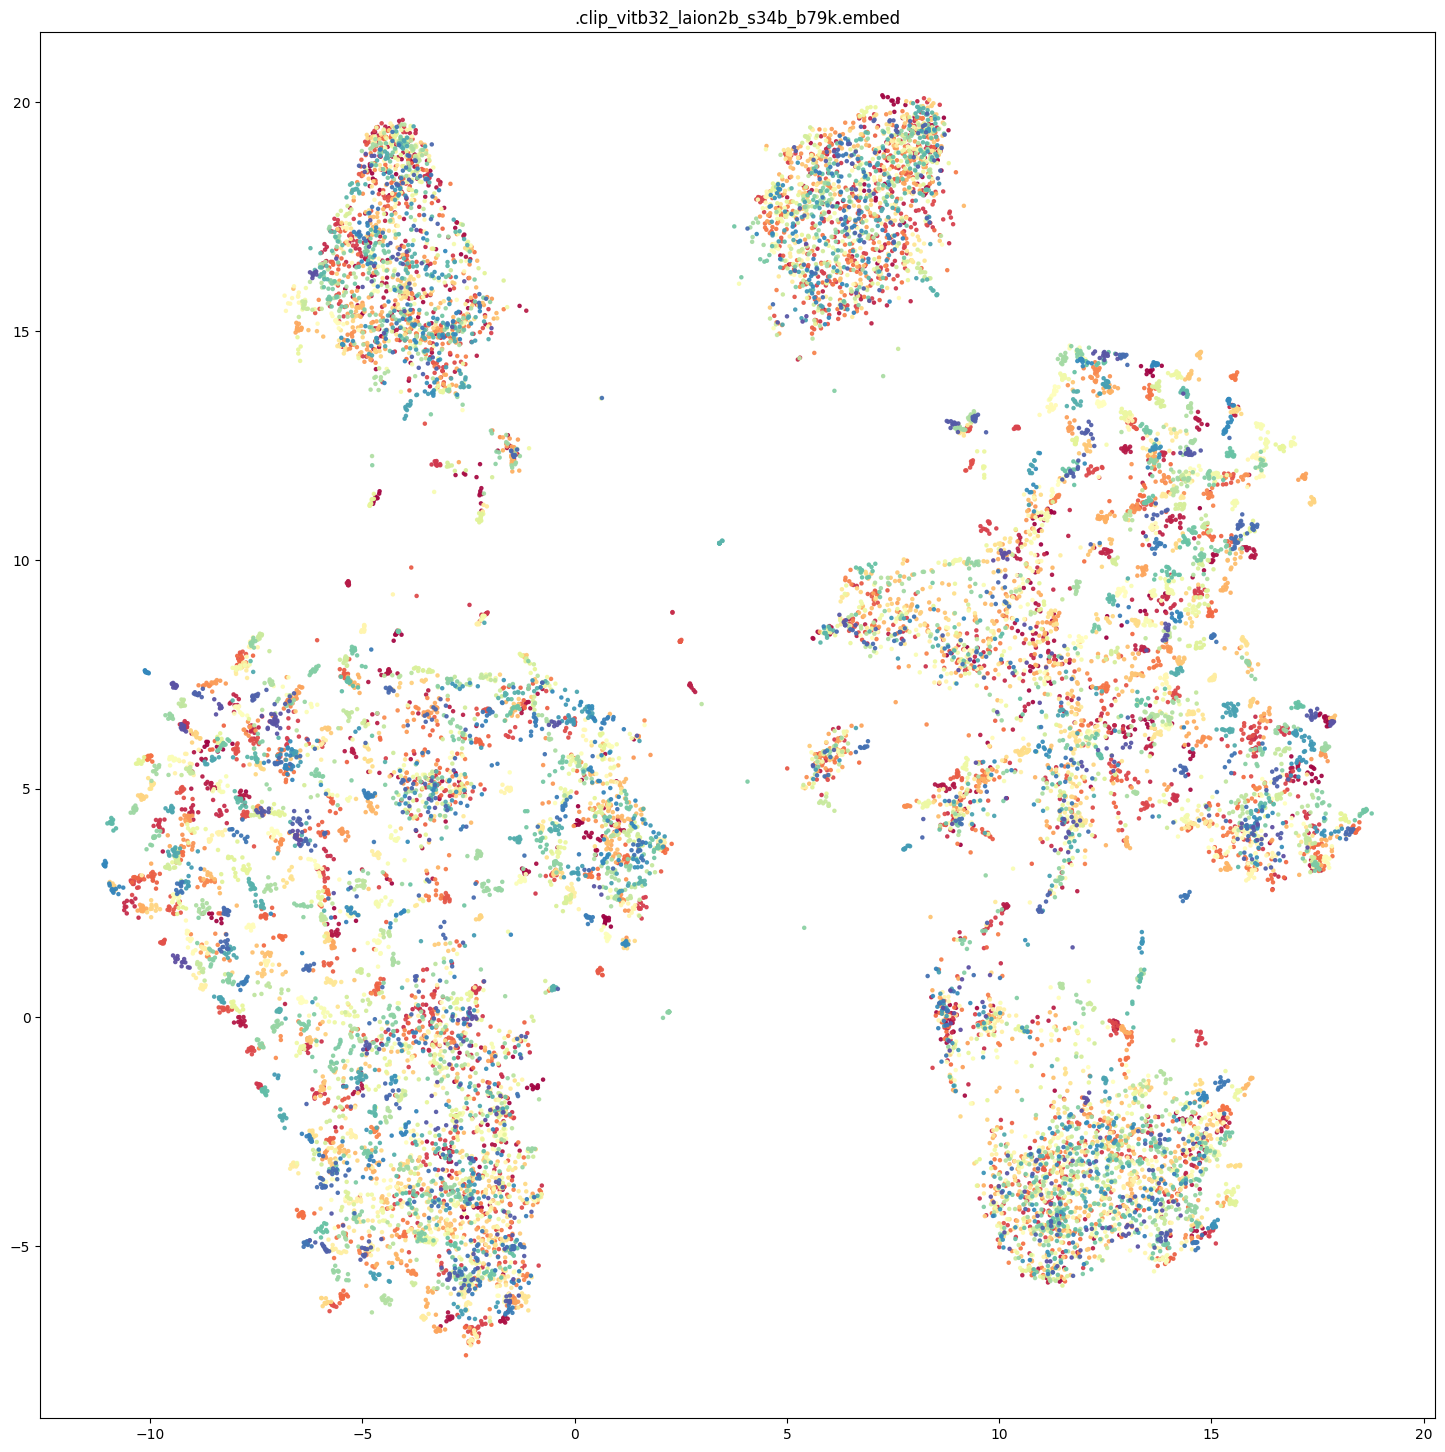

CPU times: user 9min 42s, sys: 28.8 s, total: 10min 11s
Wall time: 37.7 s


In [77]:
%%time

# vits

import umap

umap_model = umap.UMAP(
    n_neighbors=64, #20,
    #min_dist=.001,
    init='spectral',
    n_epochs=100,
    #local_connectivity=2,
    negative_sample_rate=20,
    repulsion_strength=1.5,
    #spread =1,
)
#umap_embeds = umap_model.fit_transform(df_embeds['embed_normed'], y=df_embeds['name'])
#umap_embeds = umap_model.fit_transform(embeds, classes)
umap_embeds = umap_model.fit_transform(embeds)

plt.scatter(
    *umap_embeds.T,
    s=5, 
    c=classes,
    cmap='Spectral',
    alpha=.9)
plt.title(f"{emb_suffix}")

fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.savefig("umap-unsupervised_gpt-celebs.png")

plt.show()
# WAAAAAY better

In [79]:
embeds.shape

(17100, 512)